IMPORTS AND CONFIGURATIONS


In [177]:

import json
import pickle 
import numpy as np

import nltk 

from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import matplotlib.pyplot as plt

import os



In [178]:


# i don't know why my nltk doesn't work if i don't download these 3 things. 
# if yours works without needing to download it, please comment these 3 lines out
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')




# I will be using SnowballStemmer because it is more aggressive than PorterStemmer but gentler than LancasterStemmer. 
# At the scale of this project, it doesn't matter which Stemmer I use
from nltk import SnowballStemmer
snowball = SnowballStemmer(language='english')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ellak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ellak\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ellak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [179]:

DIRECTORY_PATH = os.getcwd()

jsonfile = open(DIRECTORY_PATH + '\\data\\intents.json','r') 
intents = json.load(jsonfile)



Important Arrays

In [180]:

'''
tags = ['greeting', 'age', 'date', 'name', 'goodbye']
'''
tags = []


'''
patterns (list) is tagged. 
patterns = [["how", "are", "you"], "greeting"]
'''
patterns = []


'''
words (list) contain every word in patterns untagged
words = ["how", "are", "you", "hello", "hi", "call", "your", "name", "bye", "g2g", "see", "adios"]
'''
words = []



In [181]:
for intent in intents["intents"]: 
    
    tags.append(intent ["tag"])
    
    for pattern in intent["patterns"]: 

        tokenised_list = nltk.tokenize.word_tokenize(pattern)

        stemmed_tokenised_list = [snowball.stem(tokenised_word.lower()) for tokenised_word in tokenised_list]


        words.extend(stemmed_tokenised_list)
        patterns.append((stemmed_tokenised_list, intent["tag"]))
words = sorted(set(words))


In [182]:

'''
bag = [[input_tray, output_tray], [input_tray, output_tray], ]
where input_tray (length = len(words) )is a binary of which words in words (list) appear, and 
where output_tray (length = len(tags)) is a binary of which tags in tags (tags) appear.

'''
bag = []
for pattern in patterns: 

    input_tray = []
    for word in words: 
        input_tray.append(1) if word in pattern[0] else input_tray.append(0)
        
    output_tray = []
    for tag in tags: 
        output_tray.append(1) if tag in pattern[1] else output_tray.append(0)
    bag.append([input_tray, output_tray])


In [183]:
predictors = np.array([input_tray[0] for input_tray in bag ])
target = np.array([output_tray[1] for output_tray in bag ])

print(f"predictors: {predictors}")
print(f"target: {target}")

predictors: [[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
  0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 1]
 [0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
  0 1 0]
 [0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0
  0 1 0]
 [0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0
  0 1 0]
 [0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0
 

Neural Net with SGD

In [184]:
def get_new_model (n_cols, output_node_number): 

    '''
    ARGS
        n_cols
            number of input nodes
        output_node_number
            number of output nodes

    RETURN
        model
            Sequential model use because this model is a plain stack of layers
            2 hidden layers
                activation = 'relu'
                    if the activation output is negative, 0 activation
            1 output layer
                activation = 'sigmoid'
                    probabilities produced are independent
    '''
    model = Sequential()

    #HIDDEN LAYER 1
    model.add(Dense(256, activation = "relu", input_shape= (n_cols,)))
    model.add(Dropout(0.5))


    #HIDDEN LAYER 2
    model.add(Dense(64, activation = "relu"))
    model.add(Dropout(0.5))


    #OUTPUT LAYER
    model.add(Dense(output_node_number, activation = "sigmoid"))


        
    return model


In [185]:

model = get_new_model(len(words), len(tags))

temp_optimiser = SGD(learning_rate = 0.01, name = "SGD")


Compiling Model


In [186]:
'''
for model.compile, loss = 'categorical_crossentropy' is used instead of loss='binary_crossentropy' because in testing, 

                input   model.predict
binary          'bye'   [[0.4045582  0.25203222 0.21274081 0.23734218 0.34564596]]
categorical     'bye'   [[0.64356977 0.25627816 0.17136884 0.2590875  0.9181623 ]]

There is a far drastic difference when using categorical_crossentropy than when using binary_crossentropy
'''

"\nfor model.compile, loss = 'categorical_crossentropy' is used instead of loss='binary_crossentropy' because in testing, \n\n                input   model.predict\nbinary          'bye'   [[0.4045582  0.25203222 0.21274081 0.23734218 0.34564596]]\ncategorical     'bye'   [[0.64356977 0.25627816 0.17136884 0.2590875  0.9181623 ]]\n\nThere is a far drastic difference when using categorical_crossentropy than when using binary_crossentropy\n"

In [187]:

model.compile(optimizer = temp_optimiser, loss = "categorical_crossentropy", metrics=['accuracy'])



FIT MODEL

In [188]:

hist = model.fit ( predictors, target, epochs = 1000, verbose=False)


print(f"this is the last loss: {hist.history['loss'][-1]}")
print(f"this is the average accuracy: {hist.history['accuracy'][-1]}")


this is the last loss: 0.35735052824020386
this is the average accuracy: 0.8999999761581421


PLOT

FIG 1: loss decrease over the epochs



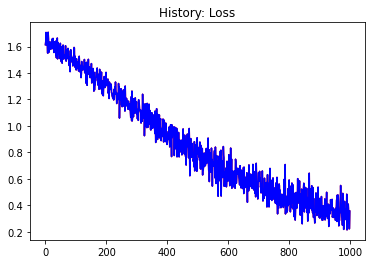

In [189]:
plt.plot(hist.history['loss'], 'r', hist.history['loss'], 'b')
  

plt.title("History: Loss")
plt.show()

FIG 2: accuracy increase over the epochs



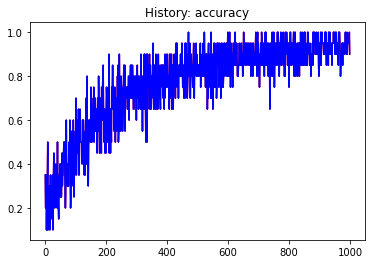

In [190]:
plt.plot(hist.history['accuracy'], 'r', hist.history['accuracy'], 'b')


plt.title("History: accuracy")
plt.show()

SAVING DATA


In [191]:

import shutil
shutil.rmtree(DIRECTORY_PATH + '\\pickle')

os.mkdir(DIRECTORY_PATH + '\\pickle')

pickle.dump (words, open(DIRECTORY_PATH + '\\pickle\\words.pkl', "wb"))
pickle.dump (tags, open(DIRECTORY_PATH + '\\pickle\\tags.pkl', "wb"))
pickle.dump (bag, open(DIRECTORY_PATH + '\\pickle\\bag.pkl', "wb"))



shutil.rmtree(DIRECTORY_PATH + "\\model")

model.save(DIRECTORY_PATH + "\\model", hist)



print("Done")


INFO:tensorflow:Assets written to: c:\Users\ellak\Documents\coding\py\fun\project chatbot\model\assets
Done


TESTING

In [192]:

'''
This commented out code can be used for testing. 

In the example below, testing shows the binary input array for "bye"
'''
testing = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

testing = tf.expand_dims(testing, axis=0)

result = model.predict(testing)

print(f"result: {result}")

result: [[0.77016056 0.33103532 0.19320393 0.11540961 0.9658521 ]]
